In [2]:
# Required Python packages
from datetime import date, datetime, timedelta
import calendar
import pandas as pd
import numpy as np
import itertools
from itertools import chain, product
import copy
from numpy.linalg import multi_dot
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.optimize import fmin_slsqp as min

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.linear_model import LassoCV
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection

from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import math
import pickle

import plotly.express as px
import plotly
plotly.offline.init_notebook_mode(connected=True)

#Import Date opertative user defined functions
from ipynb.fs.full.user_defined_vik_functions import get_all_monthly_option_expiries, \
                                                     find_last_thurs_date_of_month, \
                                                     prev_workday_if_holiday, find_wkly_expries,\
                                                     date_of_prev_thurs

# Import dataframe naming functions 
from ipynb.fs.full.user_defined_vik_functions import get_mthly_df_name_from_expiry

#Import data loading functions
from ipynb.fs.full.user_defined_vik_functions import load_all_mthly_data

#import traded options parameters and info
from ipynb.fs.full.user_defined_vik_functions import generate_weekly_strikes, generate_mthly_strikes

#Import pricing functions
from ipynb.fs.full.user_defined_vik_functions import BSM_call_vec_with_div, BSM_put_vec_with_div

#Import implied volatility processing functions
from ipynb.fs.full.user_defined_vik_functions import generate_weekly_iv, gen_interpolated_iv

#Import Risk-free interest rate generation functions
from ipynb.fs.full.user_defined_vik_functions import generate_weekly_ir

#Import Stochatic process simulation functions
from ipynb.fs.full.user_defined_vik_functions import gbm1W_simulation, generate_covariance_from_correlation

# Import risk free interest rate function
from ipynb.fs.full.user_defined_vik_functions import get_risk_free_rate_from_exact_date



In [3]:
#Stock Index of Interest
# stock_ident = "BANKNIFTY"
stock_ident = "NIFTY"

#Path to refer data
source_path = "/home/jupyter-partha/Vikranth - Chapter 2/"
input_sub_path = "Input Data/mkt_data_covid_region/"
output_sub_path = "Output Data/"
input_data_path = source_path + input_sub_path
output_data_path = source_path + output_sub_path
output_documentation_path = source_path + "doc_outputs/"

# Periods of interest will be a dictionary
#Key is the year, value is a list of months 1-12, 1- Jan, 2 - Feb,...12 - Dec
# For E.g., periods_of_interest = {2020: [3], 2019: [11, 12]}
periods_of_interest = {2019: [8, 9, 10, 11, 12], 2020: [1, 2, 3, 4, 5, 6, 7]}


#List of holidays
holidays_list = [date(2019, 3, 4), date(2019, 3, 21),\
                 date(2019, 4, 17), date(2019, 4, 19), date(2019, 4, 29),\
                 date(2019, 5, 1),\
                 date(2019, 6, 5),\
                 date(2019, 8, 12), date(2019, 8, 15),\
                 date(2019, 9, 2), date(2019, 9, 10), \
                 date(2019, 10, 2), date(2019, 10, 8), date(2019, 10, 21), date(2019, 10, 28), \
                 date(2019, 11, 12), \
                 date(2019, 12, 25), \
                 date(2020, 2, 21), \
                 date(2020, 3, 10), \
                 date(2020, 4, 2), date(2020, 4, 6), date(2020, 4, 10), date(2020,4, 14), \
                 date(2020, 5, 1), date(2020, 5, 25), \
                 date(2020, 10, 2), date(2020, 11, 16), date(2020, 11, 30), date(2020, 12, 25)]

#Simulation Parameters
no_of_paths = 5000

#Number of options
no_opt=1


In [4]:
# Generate combined Vol surface

#NOTE ON VOL SURFACE:
# 1. CE vol surface has moneyness as (S/K)
# 2. PE vol surface has moneyness as (K/S)
# 3. Combined vol surface is designed to have moneyness measure as (S/K)


# <0.95 mnyness - all call, >1.05 - all put
# only_common_strike_near_atm: 1 or 0 - if 1, only common strikes or call and put are used at ATM region (>=0.97 and <=1.03).
# if 0, common strikes (>=0.97 and <=1.03), also other strikes of calls <= 1 mnyness and put strikes with mnyness > 1 are appended
only_common_strike_near_atm = 1

mthly_expiries_list = get_all_monthly_option_expiries(periods_of_interest, holidays_list)
dict_wkly_expiries_each_month = find_wkly_expries(mthly_expiries_list, holidays_list)

df_mthly_list = []
for each_month in dict_wkly_expiries_each_month.keys():
    
    df_iv_ce = pd.read_csv(output_data_path + "A1_" + stock_ident + "_" + "Daily_vol_smile_" + "CE" + "_" + each_month + ".csv")
    df_iv_pe = pd.read_csv(output_data_path + "A1_" + stock_ident + "_" + "Daily_vol_smile_" + "PE" + "_" + each_month + ".csv")
    
    df_iv_ce['Tenor'] = df_iv_ce.apply(lambda x: str( int(round(x['T'] * 365))) + "D", axis=1)
    df_iv_pe['Tenor'] = df_iv_pe.apply(lambda x: str( int(round(x['T'] * 365))) + "D", axis=1)
    df_iv_pe['Moneyness'] = 1 / df_iv_pe['Moneyness']   
    
    df_iv_ce_tab_1 = df_iv_ce[df_iv_ce['Moneyness'] < 0.97]
    df_iv_pe_tab_1 = df_iv_pe[df_iv_pe['Moneyness'] > 1.03]
    
    df_iv_ce_tab_2a = df_iv_ce[(df_iv_ce['Moneyness'] >= 0.97) & (df_iv_ce['Moneyness'] <= 1.03)]
    df_iv_pe_tab_2a = df_iv_pe[(df_iv_pe['Moneyness'] >= 0.97) & (df_iv_pe['Moneyness'] <= 1.03)]

    df_iv_inner_mth = df_iv_ce_tab_2a.merge(df_iv_pe_tab_2a, how='inner', left_on=['Date', 'Tenor', 'Strike', 'Spot'], \
                               right_on=['Date', 'Tenor', 'Strike', 'Spot'],\
                               suffixes=('_CE', '_PE'))
    
    df_iv_inner_mth['Impl_Vol'] = (df_iv_inner_mth['Impl_Vol_CE'] + df_iv_inner_mth['Impl_Vol_PE']) / 2
    df_iv_inner_ce_pe_tab2 = df_iv_inner_mth.drop(columns=['Moneyness_PE', 'T_PE',  'Impl_Vol_PE', \
                                                            'Impl_Vol_CE'])
    
    df_iv_inner_ce_pe_tab2 = df_iv_inner_ce_pe_tab2.rename(columns={"T_CE": "T", "Moneyness_CE": "Moneyness"})
    
    df_iv_ce_tab_3a = df_iv_ce_tab_2a[df_iv_ce_tab_2a['Moneyness'] <= 1]
    df_iv_pe_tab_3a = df_iv_pe_tab_2a[df_iv_pe_tab_2a['Moneyness'] > 1]
    
    df_ce_not_required = df_iv_ce_tab_2a[df_iv_ce_tab_2a['Moneyness'] > 1]
    df_pe_not_required = df_iv_pe_tab_2a[df_iv_pe_tab_2a['Moneyness'] <= 1]
    
    df_iv_ce_tab_3 = df_iv_ce_tab_3a.merge(df_pe_not_required, how='left', left_on=['Date', 'Tenor', 'Strike', 'Spot'], \
                               right_on=['Date', 'Tenor', 'Strike', 'Spot'],\
                               suffixes=('', '_PE'))
    df_iv_ce_tab_3 = df_iv_ce_tab_3[pd.isnull(df_iv_ce_tab_3['Moneyness_PE'])]
    df_iv_ce_tab_3 = df_iv_ce_tab_3.drop(columns=['Moneyness_PE', 'Impl_Vol_PE', "T_PE"])

    
    df_iv_pe_tab_3 = df_iv_pe_tab_3a.merge(df_ce_not_required, how='left', left_on=['Date', 'Tenor', 'Strike', 'Spot'], \
                               right_on=['Date', 'Tenor', 'Strike', 'Spot'],\
                               suffixes=('', '_CE'))
    df_iv_pe_tab_3 = df_iv_pe_tab_3[pd.isnull(df_iv_pe_tab_3['Moneyness_CE'])]
    df_iv_pe_tab_3 = df_iv_pe_tab_3.drop(columns=['Moneyness_CE', 'Impl_Vol_CE', "T_CE"])    

    if (only_common_strike_near_atm == 1):
        df_iv_mth = pd.concat([df_iv_ce_tab_1, df_iv_pe_tab_1, df_iv_inner_ce_pe_tab2], axis=0)    
    else:
        df_iv_mth = pd.concat([df_iv_ce_tab_1, df_iv_pe_tab_1, df_iv_inner_ce_pe_tab2, df_iv_ce_tab_3, df_iv_pe_tab_3], axis=0)

    df_daily_iv_data = df_iv_mth
        
    df_daily_iv_data["Date_fmted"] = pd.to_datetime(df_daily_iv_data['Date'])
    df_daily_iv_data = df_daily_iv_data.sort_values(["Date_fmted", 'T', 'Moneyness'], ascending=[True, False, True]).reset_index()
    df_daily_iv_data = df_daily_iv_data.drop(columns=['Date_fmted']) 
    df_daily_iv_data["Month_Expiry"] = [each_month for i in range(0, df_daily_iv_data.shape[0])]
    df_mthly_list.append(df_daily_iv_data)

df_full_iv = pd.concat(df_mthly_list, axis=0)
df_full_iv = df_full_iv.drop(columns=['index'])
df_full_iv = df_full_iv[["Date", "Month_Expiry", "T", "Tenor", "Spot", "Strike", "Moneyness", "Impl_Vol"]]

# df_full_iv.to_csv(output_data_path + "A3_" + stock_ident + "_implied_vol_surface.csv", index = False)


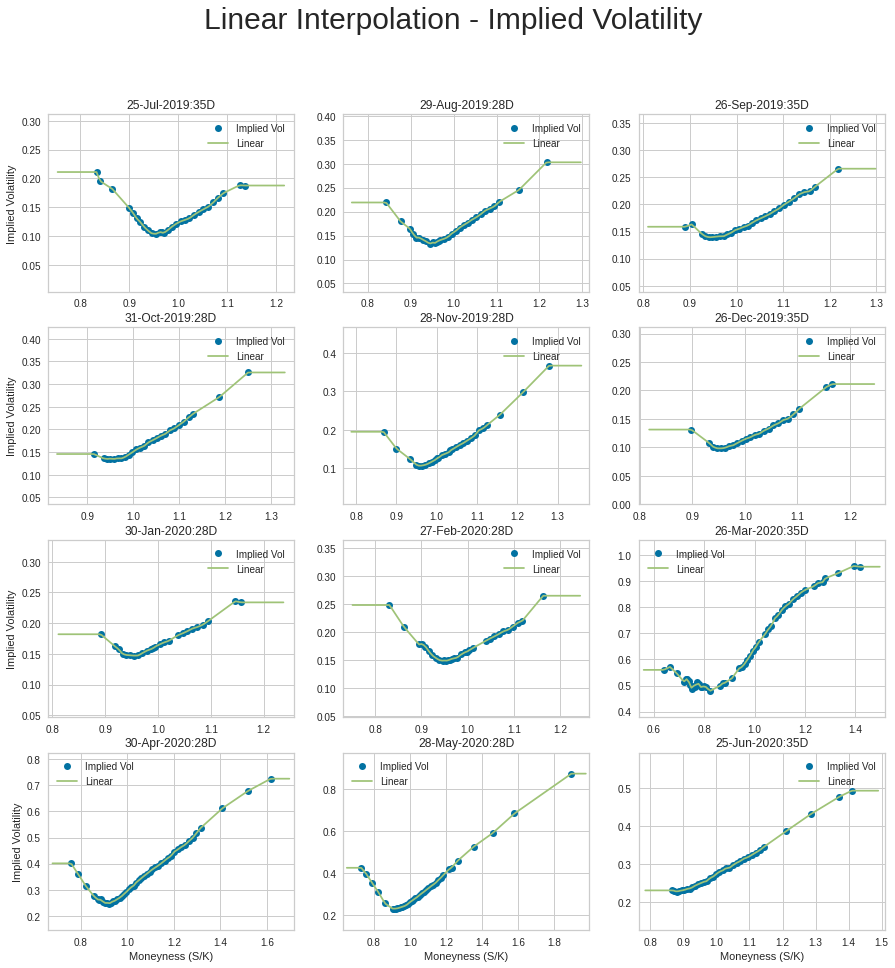

In [5]:
# Linear Interpolation - Vol Surface

#Week of interest
week = 0
tenor_of_interest =0


fig, axs = plt.subplots(4, 3, figsize=(15,15))
fig.suptitle('Linear Interpolation - Implied Volatility', fontsize=30)
plot_id_list = list(product(range(0, 4), range(0, 3)))
plot_id = 0

for each_month in dict_wkly_expiries_each_month.keys(): 
    df_week = df_full_iv[df_full_iv['Date'] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")]                  
    tenor_list = np.unique(np.array(df_week["Tenor"]))
    
    for tenor in [tenor_list[tenor_of_interest]]:
        df_tenor = df_week[df_week["Tenor"] == tenor]
        x = np.array(df_tenor["Moneyness"])
        y = np.array(df_tenor["Impl_Vol"])           
               
#         Cubic spline types based on initial and last condition: 
#         'natural', 'not-a-knot', ‘clamped’
#         cubic_spline = CubicSpline(x, y, bc_type='natural')
#         cubic_spline = CubicSpline(x, y, bc_type='natural')
                   
        x_min = max(np.amin(x) - 0.1, 0)
        x_max = np.amax(x) + 0.1
        y_min= max(0, np.amin(y) - 0.1)
        y_max = np.amax(y) + 0.1
        
        x_fit = np.linspace(np.min(x)-0.08, np.max(x)+0.08, 100)
        y_fit = np.interp(x_fit, x, y)
        y_fit[x_fit < np.min(x)] = y[x == np.min(x)]
        y_fit[x_fit > np.max(x)] = y[x == np.max(x)]

        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x, y,'o', label='Implied Vol')
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x_fit, y_fit, '-', label='Linear')
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].axis([x_min, x_max, y_min, y_max])
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set_title(dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  ":" + tenor)
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].legend()
        if (plot_id in [0,3,6,9]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(ylabel='Implied Volatility')
        if (plot_id in [9, 10, 11]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(xlabel='Moneyness (S/K)')        
            
        plot_id = plot_id + 1

if (tenor_of_interest == 0):
    tenor = "MonthlyOptions"
else:
    tenor = "WeeklyOptions"
# fig.savefig(output_data_path + "/IV/" + "A3_IV_CubicSpline_" + tenor+ "_Week" + str(week) + ".png")



In [6]:
# # Cubic Spline Interpolation

# #Week of interest
# week = 2
# tenor_of_interest =0


# fig, axs = plt.subplots(4, 3, figsize=(15,15))
# fig.suptitle('Cubic Spline Interpolation - Implied Volatility', fontsize=30)
# plot_id_list = list(product(range(0, 4), range(0, 3)))
# plot_id = 0

# for each_month in dict_wkly_expiries_each_month.keys(): 
#     df_week = df_full_iv[df_full_iv['Date'] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")]                  
#     tenor_list = np.unique(np.array(df_week["Tenor"]))
    
#     for tenor in [tenor_list[tenor_of_interest]]:
#         df_tenor = df_week[df_week["Tenor"] == tenor]
#         x = np.array(df_tenor["Moneyness"])
#         y = np.array(df_tenor["Impl_Vol"])           
               
# #         Cubic spline types based on initial and last condition: 
# #         'natural', 'not-a-knot', ‘clamped’
# #         cubic_spline = CubicSpline(x, y, bc_type='natural')
#         cubic_spline = CubicSpline(x, y, bc_type='natural')
                   
#         x_min = max(np.amin(x) - 0.1, 0)
#         x_max = np.amax(x) + 0.1
#         y_min= max(0, np.amin(y) - 0.1)
#         y_max = np.amax(y) + 0.1
        
#         x_fit = np.linspace(np.min(x)-0.08, np.max(x)+0.08, 100)
#         y_fit = cubic_spline(x_fit)
#         y_fit[x_fit < np.min(x)] = y[x == np.min(x)]
#         y_fit[x_fit > np.max(x)] = y[x == np.max(x)]

#         axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x, y,'o', label='Implied Vol')
#         axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x_fit, y_fit, '-', label='Cubic Spline')
#         axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].axis([x_min, x_max, y_min, y_max])
#         axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set_title(dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  ":" + tenor)
#         axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].legend()
#         if (plot_id in [0,3,6,9]):
#             axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(ylabel='Implied Volatility')
#         if (plot_id in [9, 10, 11]):
#             axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(xlabel='Moneyness (S/K)')        
            
#         plot_id = plot_id + 1

# if (tenor_of_interest == 0):
#     tenor = "MonthlyOptions"
# else:
#     tenor = "WeeklyOptions"
# # fig.savefig(output_data_path + "/IV/" + "A3_IV_CubicSpline_" + tenor+ "_Week" + str(week) + ".png")



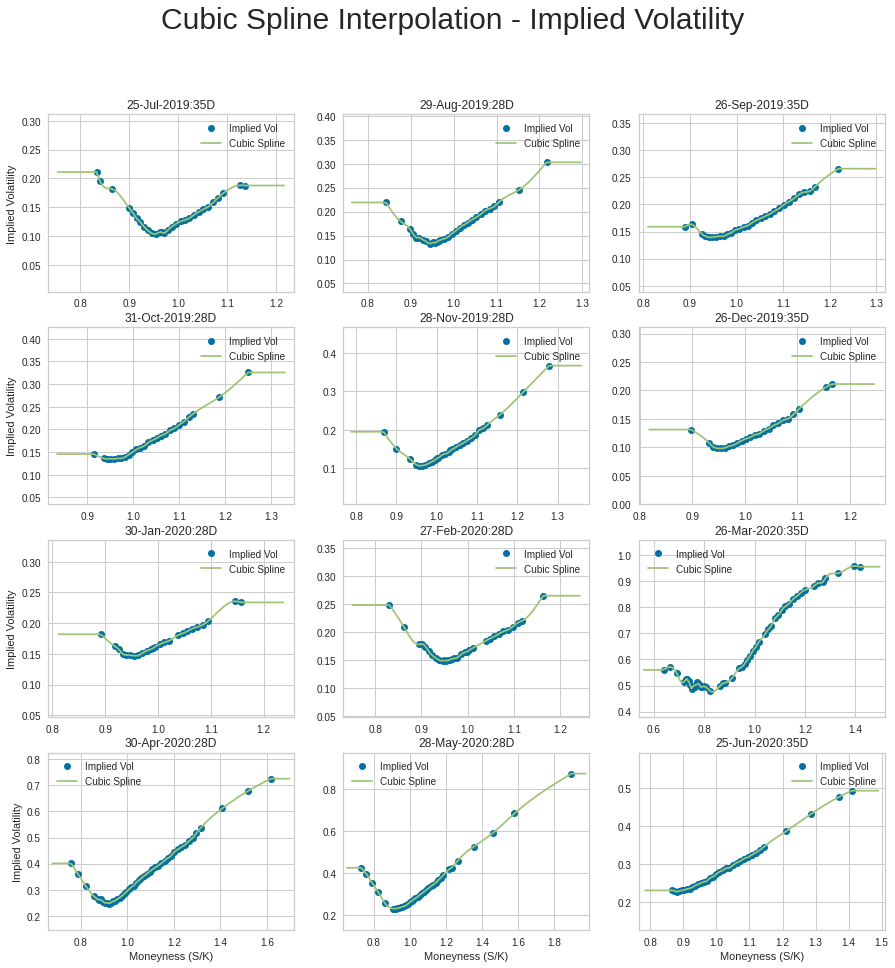

In [7]:
# Cubic Spline Interpolation

#Non-weekly plots
#Week of interest
week = 0
tenor_of_interest =0

fig, axs = plt.subplots(4, 3, figsize=(15,15))
fig.suptitle('Cubic Spline Interpolation - Implied Volatility', fontsize=30)
plot_id_list = list(product(range(0, 4), range(0, 3)))
plot_id = 0

for each_month in dict_wkly_expiries_each_month.keys(): 
    df_week = df_full_iv[df_full_iv['Date'] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")]                  
    tenor_list = np.unique(np.array(df_week["Tenor"]))
    
    for tenor in [tenor_list[tenor_of_interest]]:
        df_tenor = df_week[df_week["Tenor"] == tenor]
        x = np.array(df_tenor["Moneyness"])
        y = np.array(df_tenor["Impl_Vol"])           
               
#         Cubic spline types based on initial and last condition: 
#         'natural', 'not-a-knot', ‘clamped’
#         cubic_spline = CubicSpline(x, y, bc_type='natural')
        cubic_spline = CubicSpline(x, y, bc_type='natural')
                   
        x_min = max(np.amin(x) - 0.1, 0)
        x_max = np.amax(x) + 0.1
        y_min= max(0, np.amin(y) - 0.1)
        y_max = np.amax(y) + 0.1
        
        x_fit = np.linspace(np.min(x)-0.08, np.max(x)+0.08, 100)
        y_fit = cubic_spline(x_fit)
        y_fit[x_fit < np.min(x)] = y[x == np.min(x)]
        y_fit[x_fit > np.max(x)] = y[x == np.max(x)]

        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x, y,'o', label='Implied Vol')
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x_fit, y_fit, '-', label='Cubic Spline')
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].axis([x_min, x_max, y_min, y_max])
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set_title(dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  ":" + tenor)
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].legend()
        if (plot_id in [0,3,6,9]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(ylabel='Implied Volatility')
        if (plot_id in [9, 10, 11]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(xlabel='Moneyness (S/K)')        
            
        plot_id = plot_id + 1

if (tenor_of_interest == 0):
    tenor = "MonthlyOptions"
else:
    tenor = "WeeklyOptions"
# fig.savefig(output_data_path + "/IV/" + "A3_IV_CubicSpline_" + tenor+ "_Week" + str(week) + ".png")



In [8]:
# Quadratic Polnomial Fit


# Fitting quadratic function and getting parameters

list_of_dates = np.unique(np.array(df_full_iv['Date']))

date_time_func = lambda month: datetime.strptime(month, "%d-%b-%Y").date()
date_time_func_vec = np.vectorize(date_time_func)

date_to_string_func = lambda date_fmt: date_fmt.strftime("%d-%b-%Y")
date_to_string_func_vec = np.vectorize(date_to_string_func)

list_of_dates = date_to_string_func_vec(np.sort(date_time_func_vec(list_of_dates)))


def quad_func(x, a0, a1, a2):
    y = a0 + a1*x + a2*(np.square(x))
    return y

list_of_dfs_dates = []

for each_date in list_of_dates:
    df_date = df_full_iv[df_full_iv['Date'] == each_date]
    tenors = np.unique(np.array(df_date["Tenor"]))

    dates_list = []
    tenor_list = []
    T_list=[]
    a0_list = []
    a1_list = []
    a2_list = []
    x_min_list = []
    x_max_list = []
    for tenor in tenors:
        df_date_tenor = df_date[df_date['Tenor'] == tenor]
        t_value = np.unique(np.array(df_date_tenor["T"]))[0]
        x = np.array(df_date_tenor['Moneyness'])
        y = np.array(df_date_tenor['Impl_Vol'])
        x_min = np.amin(x)
        x_max = np.amax(x)
        
        initial_params = np.array([-1, 0, 1])
        params, pcov = curve_fit(quad_func, x, y, initial_params)
        dates_list.append(each_date)
        tenor_list.append(tenor)
        a0_list.append(params[0])
        a1_list.append(params[1])
        a2_list.append(params[2])
        T_list.append(t_value)
        x_min_list.append(x_min)
        x_max_list.append(x_max)
        
    df_each_date = pd.DataFrame({"Date": dates_list, "Tenor": tenor_list, "T":T_list, "x_min": x_min_list, "x_max": x_max_list, "a0": a0_list, "a1": a1_list, "a2": a2_list})    
    list_of_dfs_dates.append(df_each_date)
    
df_quad_params = pd.concat(list_of_dfs_dates, axis=0)
# df_quad_params.to_csv(output_data_path + "A3_" + stock_ident + "_quadPolyn_vol_surface_params.csv", index = False)
# print(df_quad_params)

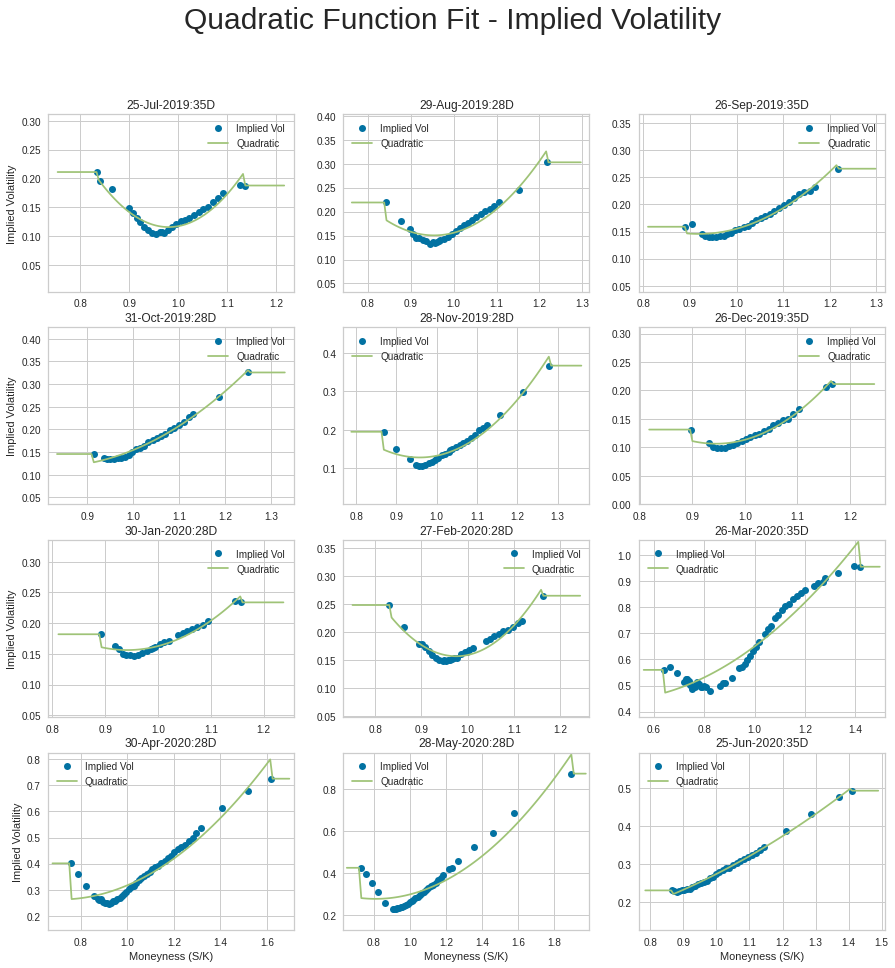

In [9]:

#Generation of quadratic fit plots
#Week of interest
week = 0
tenor_of_interest =0

fig, axs = plt.subplots(4, 3, figsize=(15,15))
fig.suptitle('Quadratic Function Fit - Implied Volatility', fontsize=30)
plot_id_list = list(product(range(0, 4), range(0, 3)))
plot_id = 0

for each_month in dict_wkly_expiries_each_month.keys(): 
    df_week = df_full_iv[df_full_iv['Date'] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")]                  
    tenor_list = np.unique(np.array(df_week["Tenor"]))
    
    for tenor in [tenor_list[tenor_of_interest]]:
        df_tenor = df_week[df_week["Tenor"] == tenor]
        x = np.array(df_tenor["Moneyness"])
        y = np.array(df_tenor["Impl_Vol"])
        
        params = list(df_quad_params[(df_quad_params["Date"] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")) & \
                                   (df_quad_params["Tenor"] == tenor)].reset_index().loc[0, ["a0", "a1","a2"]])

                   
        x_min = max(np.amin(x) - 0.1, 0)
        x_max = np.amax(x) + 0.1
        y_min= max(0, np.amin(y) - 0.1)
        y_max = np.amax(y) + 0.1

        
        x_fit = np.linspace(np.min(x)-0.08, np.max(x)+0.08, 100)
        y_fit = quad_func(x_fit, *params)
        y_fit[x_fit < np.min(x)] = y[x == np.min(x)]
        y_fit[x_fit > np.max(x)] = y[x == np.max(x)]

        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x, y,'o', label='Implied Vol')
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x_fit, y_fit, '-', label='Quadratic')
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].axis([x_min, x_max, y_min, y_max])
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set_title(dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  ":" + tenor)
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].legend()
        if (plot_id in [0,3,6,9]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(ylabel='Implied Volatility')
        if (plot_id in [9, 10, 11]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(xlabel='Moneyness (S/K)')        
            
        plot_id = plot_id + 1
            
if (tenor_of_interest == 0):
    tenor = "MonthlyOptions"
else:
    tenor = "WeeklyOptions"
    
# fig.savefig(output_data_path + "/IV/" + "A3_IV_Quadratic_" + tenor+ "_Week" + str(week) + ".png")


In [10]:
# Cubic Polynomial Fit

# Fitting cubic function and getting parameters

list_of_dates = np.unique(np.array(df_full_iv['Date']))

date_time_func = lambda month: datetime.strptime(month, "%d-%b-%Y").date()
date_time_func_vec = np.vectorize(date_time_func)

date_to_string_func = lambda date_fmt: date_fmt.strftime("%d-%b-%Y")
date_to_string_func_vec = np.vectorize(date_to_string_func)

list_of_dates = date_to_string_func_vec(np.sort(date_time_func_vec(list_of_dates)))


def cubic_func(x, a0, a1, a2, a3):
    y = a0 + a1*x + a2*(np.square(x)) + a3 * np.power(x, 3)
    return y

list_of_dfs_dates = []

for each_date in list_of_dates:
    df_date = df_full_iv[df_full_iv['Date'] == each_date]
    tenors = np.unique(np.array(df_date["Tenor"]))

    dates_list = []
    tenor_list = []
    T_list = []
    a0_list = []
    a1_list = []
    a2_list = []
    a3_list = []
    x_min_list = []
    x_max_list = []
    for tenor in tenors:
        df_date_tenor = df_date[df_date['Tenor'] == tenor]
        t_value = np.unique(np.array(df_date_tenor['T']))[0]
        x = np.array(df_date_tenor['Moneyness'])
        y = np.array(df_date_tenor['Impl_Vol'])
        x_min = np.amin(x)
        x_max = np.amax(x)
        
        initial_params = np.array([-1, 0, 1, 0])
        params, pcov = curve_fit(cubic_func, x, y, initial_params)
        dates_list.append(each_date)
        tenor_list.append(tenor)
        a0_list.append(params[0])
        a1_list.append(params[1])
        a2_list.append(params[2])
        a3_list.append(params[3])
        T_list.append(t_value)
        x_min_list.append(x_min)
        x_max_list.append(x_max)       
        
    df_each_date = pd.DataFrame({"Date": dates_list, "Tenor": tenor_list, "T":T_list, "x_min":x_min_list, "x_max":x_max_list,  "a0": a0_list, "a1": a1_list, "a2": a2_list, "a3": a3_list})    
    list_of_dfs_dates.append(df_each_date)
    
df_cubic_params = pd.concat(list_of_dfs_dates, axis=0)
# df_cubic_params.to_csv(output_data_path + "A3_" + stock_ident + "_cubicPolyn_vol_surface_params.csv", index = False)
# print(df_cubic_params)

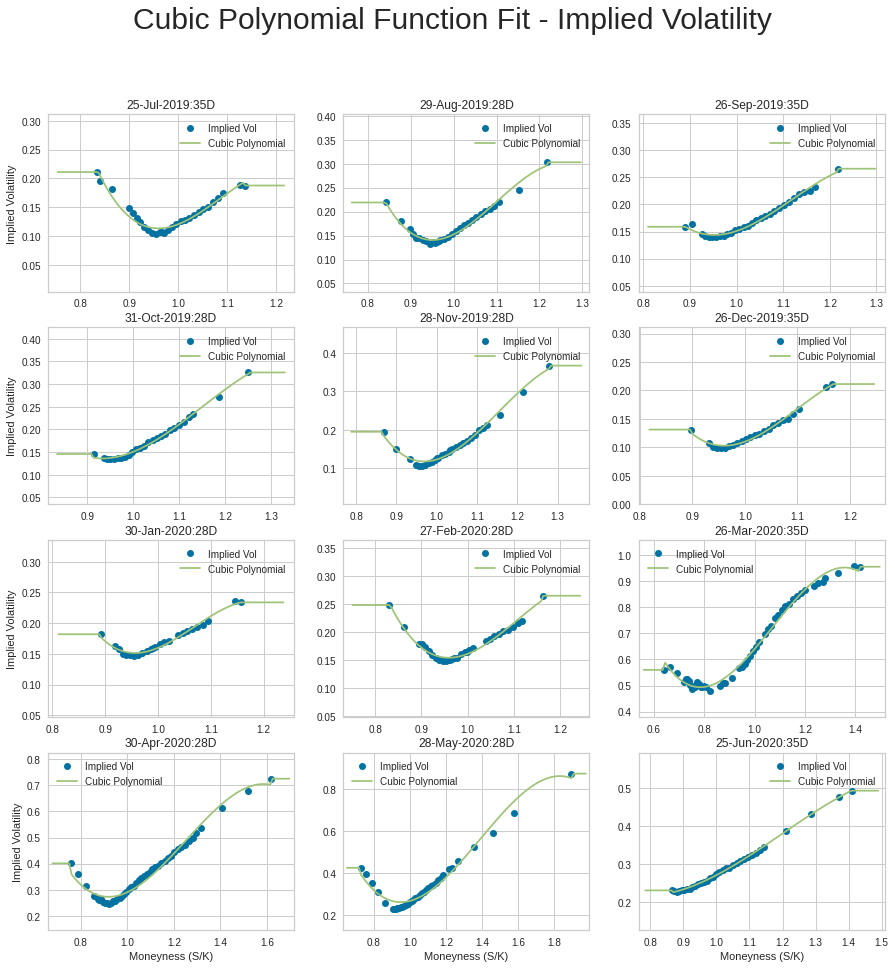

In [11]:
# Cubic Polynomial Fit

#Generation of cubic fit plots
#Week of interest
week = 0
tenor_of_interest =0

fig, axs = plt.subplots(4, 3, figsize=(15,15))
fig.suptitle('Cubic Polynomial Function Fit - Implied Volatility', fontsize=30)
plot_id_list = list(product(range(0, 4), range(0, 3)))
plot_id = 0

for each_month in dict_wkly_expiries_each_month.keys(): 
    df_week = df_full_iv[df_full_iv['Date'] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")]                  
    tenor_list = np.unique(np.array(df_week["Tenor"]))
    
    for tenor in [tenor_list[tenor_of_interest]]:
        df_tenor = df_week[df_week["Tenor"] == tenor]
        x = np.array(df_tenor["Moneyness"])
        y = np.array(df_tenor["Impl_Vol"])
        
        params = list(df_cubic_params[(df_cubic_params["Date"] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")) & \
                                   (df_cubic_params["Tenor"] == tenor)].reset_index().loc[0, ["a0", "a1","a2", "a3"]])
                   
        x_min = max(np.amin(x) - 0.1, 0)
        x_max = np.amax(x) + 0.1
        y_min= max(0, np.amin(y) - 0.1)
        y_max = np.amax(y) + 0.1

        
        x_fit = np.linspace(np.min(x)-0.08, np.max(x)+0.08, 100)
        y_fit = cubic_func(x_fit, *params)
        y_fit[x_fit < np.min(x)] = y[x == np.min(x)]
        y_fit[x_fit > np.max(x)] = y[x == np.max(x)]

        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x, y,'o', label='Implied Vol')
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x_fit, y_fit, '-', label='Cubic Polynomial')
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].axis([x_min, x_max, y_min, y_max])
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set_title(dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  ":" + tenor)
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].legend()
        if (plot_id in [0,3,6,9]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(ylabel='Implied Volatility')
        if (plot_id in [9, 10, 11]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(xlabel='Moneyness (S/K)')        
            
        plot_id = plot_id + 1
            
if (tenor_of_interest == 0):
    tenor = "MonthlyOptions"
else:
    tenor = "WeeklyOptions"
# fig.savefig(output_data_path + "/IV/" + "A3_IV_Quadratic_" + tenor + "_Week" + str(week) + ".png")


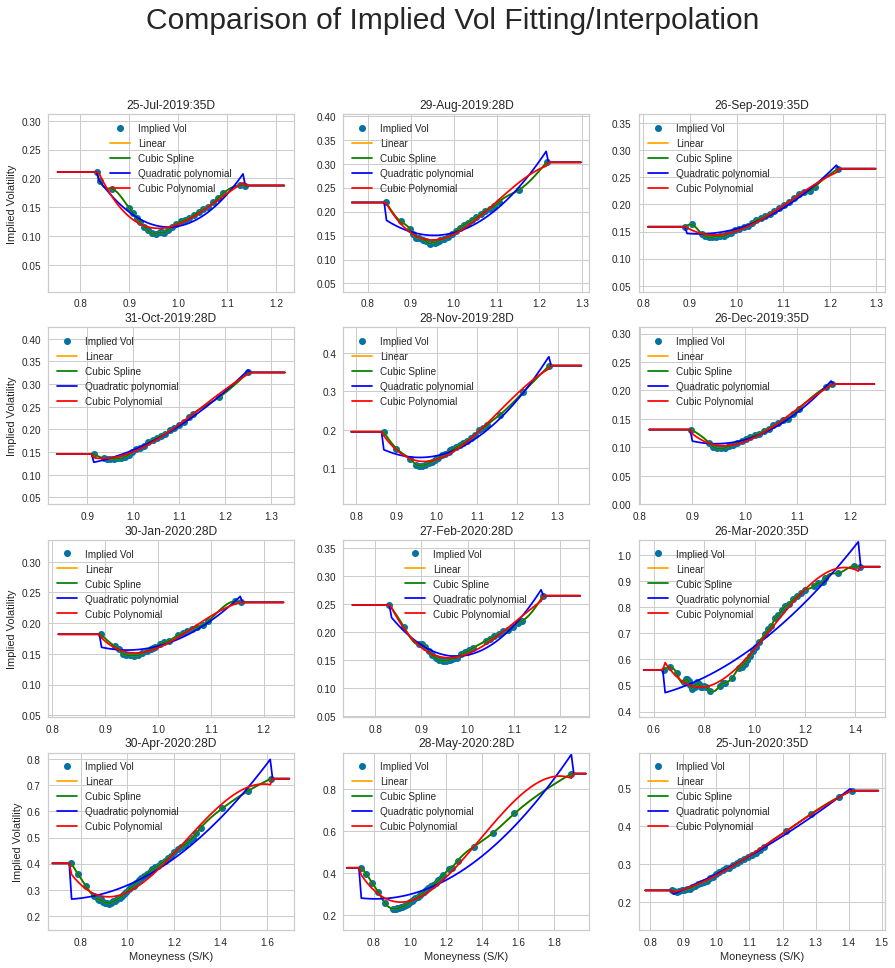

In [12]:
# Comparison of fitting/interpolation - Cubic Spline, quadratic, cubic polynomial

#Week of interest
week = 0
tenor_of_interest =0


fig, axs = plt.subplots(4, 3, figsize=(15,15))
fig.suptitle('Comparison of Implied Vol Fitting/Interpolation', fontsize=30)
plot_id_list = list(product(range(0, 4), range(0, 3)))
plot_id = 0

for each_month in dict_wkly_expiries_each_month.keys(): 
    df_week = df_full_iv[df_full_iv['Date'] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")]                  
    tenor_list = np.unique(np.array(df_week["Tenor"]))
    
    for tenor in [tenor_list[tenor_of_interest]]:
        df_tenor = df_week[df_week["Tenor"] == tenor]
        x = np.array(df_tenor["Moneyness"])
        y = np.array(df_tenor["Impl_Vol"])   

        quad_params = list(df_quad_params[(df_quad_params["Date"] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")) & \
                                   (df_quad_params["Tenor"] == tenor)].reset_index().loc[0, ["a0", "a1","a2"]])
              
        cubic_params = list(df_cubic_params[(df_cubic_params["Date"] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")) & \
                                   (df_cubic_params["Tenor"] == tenor)].reset_index().loc[0, ["a0", "a1","a2", "a3"]])
        
               
#         Cubic spline types based on initial and last condition: 
#         'natural', 'not-a-knot', ‘clamped’
#         cubic_spline = CubicSpline(x, y, bc_type='natural')
        cubic_spline = CubicSpline(x, y, bc_type='natural')
                   
        x_min = max(np.amin(x) - 0.1, 0)
        x_max = np.amax(x) + 0.1
        y_min= max(0, np.amin(y) - 0.1)
        y_max = np.amax(y) + 0.1

        
        x_fit = np.linspace(np.min(x)-0.08, np.max(x)+0.08, 100)
        
        y_linear_fit = np.interp(x_fit, x, y)
        y_linear_fit[x_fit < np.min(x)] = y[x == np.min(x)]
        y_linear_fit[x_fit > np.max(x)] = y[x == np.max(x)]
        
        y_fit = cubic_spline(x_fit)
        y_fit[x_fit < np.min(x)] = y[x == np.min(x)]
        y_fit[x_fit > np.max(x)] = y[x == np.max(x)]
        
        y_quad_fit = quad_func(x_fit, *quad_params)
        y_quad_fit[x_fit < np.min(x)] = y[x == np.min(x)]
        y_quad_fit[x_fit > np.max(x)] = y[x == np.max(x)]
        
        y_cubic_fit = cubic_func(x_fit, *cubic_params)
        y_cubic_fit[x_fit < np.min(x)] = y[x == np.min(x)]
        y_cubic_fit[x_fit > np.max(x)] = y[x == np.max(x)]

        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x, y,'o', label='Implied Vol')
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x_fit, y_fit, '-', label='Linear', color="orange")
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x_fit, y_fit, '-', label='Cubic Spline', color="green")
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x_fit, y_quad_fit, '-', label='Quadratic polynomial', color="blue")        
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x_fit, y_cubic_fit, '-', label='Cubic Polynomial', color="red")        
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].axis([x_min, x_max, y_min, y_max])
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set_title(dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  ":" + tenor)
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].legend()
        if (plot_id in [0,3,6,9]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(ylabel='Implied Volatility')
        if (plot_id in [9, 10, 11]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(xlabel='Moneyness (S/K)')        
            
        plot_id = plot_id + 1

if (tenor_of_interest == 0):
    tenor = "MonthlyOptions"
else:
    tenor = "WeeklyOptions"

fig.savefig(output_documentation_path + "A3_IV_CubicSpline_" + tenor+ "_Week" + str(week) + ".png")



In [13]:
# periods_of_interest = {2019: [8, 9, 10, 11, 12], 2020: [1, 2, 3, 4, 5, 6, 7]}
# # periods_of_interest = {2019: [11]}
# week = 0

# #Find the monthly strikes of option from mkt data to find the option to be hedged
# #Every month, an option is hedged
# mthly_expiries_list = get_all_monthly_option_expiries(periods_of_interest, holidays_list)
# dict_wkly_expiries_each_month = find_wkly_expries(mthly_expiries_list, holidays_list)

# df_mthly_list = []
# for each_month in dict_wkly_expiries_each_month.keys():
#     #Please note vol smile is same for European Call and Put
    
    
#     df_iv_ce = pd.read_csv(output_data_path + "A1_" + stock_ident + "_" + "Daily_vol_smile_" + "CE" + "_" + each_month + ".csv")
#     df_iv_pe = pd.read_csv(output_data_path + "A1_" + stock_ident + "_" + "Daily_vol_smile_" + "PE" + "_" + each_month + ".csv")
#     df_iv_ce['Tenor'] = df_iv_ce.apply(lambda x: str( int(round(x['T'] * 365))) + "D", axis=1)
#     df_iv_pe['Tenor'] = df_iv_pe.apply(lambda x: str( int(round(x['T'] * 365))) + "D", axis=1)
#     df_iv_pe['Moneyness'] = 1 / df_iv_pe['Moneyness']   
    
#     df_iv_ce_tab_1 = df_iv_ce[df_iv_ce['Moneyness'] < 0.98]
#     df_iv_pe_tab_1 = df_iv_pe[df_iv_pe['Moneyness'] > 1.02]
    
#     df_iv_ce_tab_2a = df_iv_ce[(df_iv_ce['Moneyness'] >= 0.98) & (df_iv_ce['Moneyness'] <= 1.02)]
#     df_iv_pe_tab_2a = df_iv_pe[(df_iv_pe['Moneyness'] >= 0.98) & (df_iv_pe['Moneyness'] <= 1.02)]

#     df_iv_inner_mth = df_iv_ce_tab_2a.merge(df_iv_pe_tab_2a, how='inner', left_on=['Date', 'Tenor', 'Strike', 'Spot'], \
#                                right_on=['Date', 'Tenor', 'Strike', 'Spot'],\
#                                suffixes=('_CE', '_PE'))
    
#     df_iv_inner_mth['Impl_Vol'] = (df_iv_inner_mth['Impl_Vol_CE'] + df_iv_inner_mth['Impl_Vol_PE']) / 2
#     df_iv_inner_ce_pe_tab2 = df_iv_inner_mth.drop(columns=['Moneyness_PE', 'T_PE',  'Impl_Vol_PE', \
#                                                             'Impl_Vol_CE'])
    
#     df_iv_inner_ce_pe_tab2 = df_iv_inner_ce_pe_tab2.rename(columns={"T_CE": "T", "Moneyness_CE": "Moneyness"})
    
# #     df_iv_ce_tab_3a = df_iv_ce_tab_2a[df_iv_ce_tab_2a['Moneyness'] <= 1]
# #     df_iv_pe_tab_3a = df_iv_pe_tab_2a[df_iv_pe_tab_2a['Moneyness'] > 1]
    
# #     df_ce_not_required = df_iv_ce_tab_2a[df_iv_ce_tab_2a['Moneyness'] > 1]
# #     df_pe_not_required = df_iv_pe_tab_2a[df_iv_pe_tab_2a['Moneyness'] <= 1]
    
# #     df_iv_ce_tab_3 = df_iv_ce_tab_3a.merge(df_pe_not_required, how='left', left_on=['Date', 'Tenor', 'Strike', 'Spot'], \
# #                                right_on=['Date', 'Tenor', 'Strike', 'Spot'],\
# #                                suffixes=('', '_PE'))
# #     df_iv_ce_tab_3 = df_iv_ce_tab_3[pd.isnull(df_iv_ce_tab_3['Moneyness_PE'])]
# #     df_iv_ce_tab_3 = df_iv_ce_tab_3.drop(columns=['Moneyness_PE', 'Impl_Vol_PE', "T_PE"])

    
# #     df_iv_pe_tab_3 = df_iv_pe_tab_3a.merge(df_ce_not_required, how='left', left_on=['Date', 'Tenor', 'Strike', 'Spot'], \
# #                                right_on=['Date', 'Tenor', 'Strike', 'Spot'],\
# #                                suffixes=('', '_CE'))
# #     df_iv_pe_tab_3 = df_iv_pe_tab_3[pd.isnull(df_iv_pe_tab_3['Moneyness_CE'])]
# #     df_iv_pe_tab_3 = df_iv_pe_tab_3.drop(columns=['Moneyness_CE', 'Impl_Vol_CE', "T_CE"])    

#     df_iv_mth = pd.concat([df_iv_ce_tab_1, df_iv_pe_tab_1, df_iv_inner_ce_pe_tab2], axis=0)
   
#     df_daily_iv_data = df_iv_mth
# #     df_daily_iv_data = df_daily_iv_data[df_daily_iv_data['Date'] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")]
    
#     df_daily_iv_data = df_daily_iv_data[(df_daily_iv_data['Date'] == dict_wkly_expiries_each_month[each_month][0].strftime("%d-%b-%Y")) | \
#                                        (df_daily_iv_data['Date'] == dict_wkly_expiries_each_month[each_month][1].strftime("%d-%b-%Y")) | \
#                                        (df_daily_iv_data['Date'] == dict_wkly_expiries_each_month[each_month][2].strftime("%d-%b-%Y"))]

#     df_daily_iv_data["Date_fmted"] = pd.to_datetime(df_daily_iv_data['Date'])
#     df_daily_iv_data = df_daily_iv_data.sort_values(["Date_fmted", 'T', 'Moneyness'], ascending=[True, False, True]).reset_index()
#     df_daily_iv_data = df_daily_iv_data.drop(columns=['Date_fmted'])
    

#     colours_plot = px.colors.qualitative.Plotly
#     colours_plot =colours_plot + ['rgb(166,118,29)', 'rgb(124,124,124)']
#     fig = px.scatter(df_daily_iv_data, x="Moneyness", y="Impl_Vol", facet_col="Tenor", color="Date", trendline="lowess", \
#                  color_discrete_sequence=colours_plot)
#     fig.show() 

    
#     df_mthly_list.append(df_daily_iv_data)

# df_plot = pd.concat(df_mthly_list, axis=0)
# colours_plot = px.colors.qualitative.Plotly
# colours_plot =colours_plot + ['rgb(166,118,29)', 'rgb(124,124,124)']

# # fig = px.scatter(df_plot, x="Moneyness", y="Impl_Vol", facet_col="Tenor", color="Date", trendline="lowess", \
# #                 color_discrete_sequence=px.colors.qualitative.Dark24)
# # fig = px.scatter(df_plot, x="Moneyness", y="Impl_Vol", facet_col="Tenor", color="Date", trendline="lowess", \
# #                  color_discrete_sequence=colours_plot)
# # fig = px.scatter(df_plot, x="Moneyness", y="Impl_Vol", facet_col="Tenor", color="Date", trendline="lowess", \
# #                  color_discrete_sequence=colours_plot)
# # fig.show() 
# # # fig.savefig(output_data_path + "Fig_Implied_VolSurface.png")


In [ ]:
# week = 0
# for each_month in dict_wkly_expiries_each_month.keys(): 
#     df_week = df_full_iv[df_full_iv['Date'] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")]                  
#     tenor_list = np.unique(np.array(df_week["Tenor"]))

#     for tenor in [tenor_list[0]]:
#         df_tenor = df_week[df_week["Tenor"] == tenor]
#         x = np.array(df_tenor["Moneyness"])
#         y = np.array(df_tenor["Impl_Vol"])

        
# #         Cubic spline types based on initial and last condition: 
# #         'natural', 'not-a-knot', ‘clamped’
# #         cubic_spline = CubicSpline(x, y, bc_type='natural')
#         cubic_spline = CubicSpline(x, y, bc_type='natural')
                   
#         x_min = max(np.amin(x) - 0.1, 0)
#         x_max = np.amax(x) + 0.1
#         y_min= max(0, np.amin(y) - 0.1)
#         y_max = np.amax(y) + 0.1

        
#         x_fit = np.linspace(np.min(x)-0.08, np.max(x)+0.08, 100)
#         y_fit = cubic_spline(x_fit)
#         y_fit[x_fit < np.min(x)] = y[x == np.min(x)]
#         y_fit[x_fit > np.max(x)] = y[x == np.max(x)]


#         plt.plot(x, y, 'o', label='Impl_Vol')
#         plt.plot(x_fit, y_fit, '-', label='Cubic Spline')
#         plt.axis([x_min, x_max, y_min, y_max])
#         plt.xlabel('Moneyness (S/K)') 
#         plt.ylabel('Implied Volatility') 
#         plt.title("IV Parameterisation - " + dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  "_" + tenor)
#         plt.legend()
# #         plt.savefig(output_data_path + "/IV/" + "A3_IV Parameterisation - " + dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  "_" + tenor + ".png")
#         plt.show()

# #         df_tenor.to_csv(output_data_path + "/IV/" + "A3_IV Parameterisation - " + dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  "_" + tenor + ".csv")        
            
        


In [ ]:
# # Generate combined Vol surface

# mthly_expiries_list = get_all_monthly_option_expiries(periods_of_interest, holidays_list)
# dict_wkly_expiries_each_month = find_wkly_expries(mthly_expiries_list, holidays_list)

# df_mthly_list = []
# for each_month in dict_wkly_expiries_each_month.keys():
    
#     df_iv_ce = pd.read_csv(output_data_path + "A1_" + stock_ident + "_" + "Daily_vol_smile_" + "CE" + "_" + each_month + ".csv")
#     df_iv_pe = pd.read_csv(output_data_path + "A1_" + stock_ident + "_" + "Daily_vol_smile_" + "PE" + "_" + each_month + ".csv")
#     df_iv_ce['Tenor'] = df_iv_ce.apply(lambda x: str( int(round(x['T'] * 365))) + "D", axis=1)
#     df_iv_pe['Tenor'] = df_iv_pe.apply(lambda x: str( int(round(x['T'] * 365))) + "D", axis=1)
#     df_iv_pe['Moneyness'] = 1 / df_iv_pe['Moneyness']   
    
#     df_iv_ce_tab_1 = df_iv_ce[df_iv_ce['Moneyness'] < 0.97]
#     df_iv_pe_tab_1 = df_iv_pe[df_iv_pe['Moneyness'] > 1.03]
    
#     df_iv_ce_tab_2a = df_iv_ce[(df_iv_ce['Moneyness'] >= 0.97) & (df_iv_ce['Moneyness'] <= 1.03)]
#     df_iv_pe_tab_2a = df_iv_pe[(df_iv_pe['Moneyness'] >= 0.97) & (df_iv_pe['Moneyness'] <= 1.03)]

#     df_iv_inner_mth = df_iv_ce_tab_2a.merge(df_iv_pe_tab_2a, how='inner', left_on=['Date', 'Tenor', 'Strike', 'Spot'], \
#                                right_on=['Date', 'Tenor', 'Strike', 'Spot'],\
#                                suffixes=('_CE', '_PE'))
    
#     df_iv_inner_mth['Impl_Vol'] = (df_iv_inner_mth['Impl_Vol_CE'] + df_iv_inner_mth['Impl_Vol_PE']) / 2
#     df_iv_inner_ce_pe_tab2 = df_iv_inner_mth.drop(columns=['Moneyness_PE', 'T_PE',  'Impl_Vol_PE', \
#                                                             'Impl_Vol_CE'])
    
#     df_iv_inner_ce_pe_tab2 = df_iv_inner_ce_pe_tab2.rename(columns={"T_CE": "T", "Moneyness_CE": "Moneyness"})
    
#     df_iv_ce_tab_3a = df_iv_ce_tab_2a[df_iv_ce_tab_2a['Moneyness'] <= 1]
#     df_iv_pe_tab_3a = df_iv_pe_tab_2a[df_iv_pe_tab_2a['Moneyness'] > 1]
    
#     df_ce_not_required = df_iv_ce_tab_2a[df_iv_ce_tab_2a['Moneyness'] > 1]
#     df_pe_not_required = df_iv_pe_tab_2a[df_iv_pe_tab_2a['Moneyness'] <= 1]
    
#     df_iv_ce_tab_3 = df_iv_ce_tab_3a.merge(df_pe_not_required, how='left', left_on=['Date', 'Tenor', 'Strike', 'Spot'], \
#                                right_on=['Date', 'Tenor', 'Strike', 'Spot'],\
#                                suffixes=('', '_PE'))
#     df_iv_ce_tab_3 = df_iv_ce_tab_3[pd.isnull(df_iv_ce_tab_3['Moneyness_PE'])]
#     df_iv_ce_tab_3 = df_iv_ce_tab_3.drop(columns=['Moneyness_PE', 'Impl_Vol_PE', "T_PE"])

    
#     df_iv_pe_tab_3 = df_iv_pe_tab_3a.merge(df_ce_not_required, how='left', left_on=['Date', 'Tenor', 'Strike', 'Spot'], \
#                                right_on=['Date', 'Tenor', 'Strike', 'Spot'],\
#                                suffixes=('', '_CE'))
#     df_iv_pe_tab_3 = df_iv_pe_tab_3[pd.isnull(df_iv_pe_tab_3['Moneyness_CE'])]
#     df_iv_pe_tab_3 = df_iv_pe_tab_3.drop(columns=['Moneyness_CE', 'Impl_Vol_CE', "T_CE"])    

#     df_iv_mth = pd.concat([df_iv_ce_tab_1, df_iv_pe_tab_1, df_iv_inner_ce_pe_tab2, df_iv_ce_tab_3, df_iv_pe_tab_3], axis=0)
# #     df_iv_mth = pd.concat([df_iv_ce_tab_1, df_iv_pe_tab_1, df_iv_inner_ce_pe_tab2], axis=0)
   
#     df_daily_iv_data = df_iv_mth
        
#     df_daily_iv_data["Date_fmted"] = pd.to_datetime(df_daily_iv_data['Date'])
#     df_daily_iv_data = df_daily_iv_data.sort_values(["Date_fmted", 'T', 'Moneyness'], ascending=[True, False, True]).reset_index()
#     df_daily_iv_data = df_daily_iv_data.drop(columns=['Date_fmted']) 
    
#     df_mthly_list.append(df_daily_iv_data)

# df_full_iv = pd.concat(df_mthly_list, axis=0)
# df_full_iv.to_csv(output_data_path + "A3_" + stock_ident + "_implied_vol_surface.csv", index = False)

# list_of_dates = np.unique(np.array(df_full_iv['Date']))

# date_time_func = lambda month: datetime.strptime(month, "%d-%b-%Y").date()
# date_time_func_vec = np.vectorize(date_time_func)

# date_to_string_func = lambda date_fmt: date_fmt.strftime("%d-%b-%Y")
# date_to_string_func_vec = np.vectorize(date_to_string_func)

# list_of_dates = date_to_string_func_vec(np.sort(date_time_func_vec(list_of_dates)))


# def quad_func(x, a0, a1, a2):
#     y = a0 + a1*x + a2*(np.square(x))
#     return y

# list_of_dfs_dates = []

# for each_date in list_of_dates:
#     df_date = df_full_iv[df_full_iv['Date'] == each_date]
#     tenors = np.unique(np.array(df_date["Tenor"]))

#     dates_list = []
#     tenor_list = []
#     a0_list = []
#     a1_list = []
#     a2_list = []
#     for tenor in tenors:
#         df_date_tenor = df_date[df_date['Tenor'] == tenor]
#         x = np.array(df_date_tenor['Moneyness'])
#         y = np.array(df_date_tenor['Impl_Vol'])
#         initial_params = np.array([-1, 0, 1])
#         params, pcov = curve_fit(quad_func, x, y, initial_params)
#         dates_list.append(each_date)
#         tenor_list.append(tenor)
#         a0_list.append(params[0])
#         a1_list.append(params[1])
#         a2_list.append(params[2])
        
#     df_each_date = pd.DataFrame({"Date": dates_list, "Tenor": tenor_list, "a0": a0_list, "a1": a1_list, "a2": a2_list})    
#     list_of_dfs_dates.append(df_each_date)
    
# df_quad_params = pd.concat(list_of_dfs_dates, axis=0)

# week = 0
# for each_month in dict_wkly_expiries_each_month.keys():
#     df_week = df_full_iv[df_full_iv['Date'] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")]                  
#     tenor_list = np.unique(np.array(df_week["Tenor"]))

#     for tenor in tenor_list:
#         df_tenor = df_week[df_week["Tenor"] == tenor]
#         x = np.array(df_tenor["Moneyness"])
#         y = np.array(df_tenor["Impl_Vol"])
        
#         params = list(df_quad_params[(df_quad_params["Date"] == dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y")) & \
#                                    (df_quad_params["Tenor"] == tenor)].reset_index().loc[0, ["a0", "a1","a2"]])
           
#         x_min = np.min(x) - 0.1
#         x_max = np.max(x) + 0.1
#         x_fit = np.linspace(np.min(x)-0.05, np.max(x)+0.05, 100)
#         y_fit = quad_func(x_fit, *params)
#         y_min= max(0, np.min(y) - 0.1, np.min(y_fit) -0.1)
#         y_max = max(np.max(y) + 0.1, np.max(y_fit) + 0.1)

        

#         plt.plot(x, y, 'o', label='Impl_Vol')
#         plt.plot(x_fit, y_fit, '-', label='Quadratic Fit')
#         plt.axis([x_min, x_max, y_min, y_max])
#         plt.xlabel('Moneyness (S/K)') 
#         plt.ylabel('Implied Volatility') 
#         plt.title("IV Parameterisation - " + dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  "_" + tenor)
#         plt.legend()
#         plt.savefig(output_data_path + "/IV/" + "A3_IV Parameterisation - " + dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  "_" + tenor + ".png")
#         plt.show()

#         df_tenor.to_csv(output_data_path + "/IV/" + "A3_IV Parameterisation - " + dict_wkly_expiries_each_month[each_month][week].strftime("%d-%b-%Y") +  "_" + tenor + ".csv")        
            
           